# Learning curves - Compare between all data sources using the same ML model
The main function of this notebook `plot_agg_lrn_crv()` is integrated in `apps/lrn_crv/launch_lrn_crv.py`.<br>

This code processes learning curve results from the output of `apps/lrn_crv/launch_lrn_crv.py`.<br>
It takes a master folder (e.g. `out/lrn_crv/lrn_crv_lgb_reg_cvf5`) that contains the runs (`apps/lrn_crv/tr_lrn_crv.py`) for each of the cell line datasets.<br>
It generates learning curve plots for each metric (each plot contains all the data sources).<br>

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# new
run_path = Path('../out/lrn_crv/lrn_crv_lgb_reg_cvf5')
rslt_fname = 'lrn_crv_all.csv'
df = pd.read_csv(run_path / rslt_fname)

In [3]:
# # old data
# run_path = Path('../models/from_combined/lrn_curves~2019-2-6_h23-m23')

# # old data
# dd = {'ccle':  run_path / 'ccle.lgb_reg.simple.rna.dsc.AUC~2019-2-6_h23-m24/',
#       'ctrp':  run_path / 'ctrp.lgb_reg.simple.rna.dsc.AUC~2019-2-6_h23-m37/',
#       'gcsi':  run_path / 'gcsi.lgb_reg.simple.rna.dsc.AUC~2019-2-6_h23-m23/',
#       'gdsc':  run_path / 'gdsc.lgb_reg.simple.rna.dsc.AUC~2019-2-6_h23-m26/',
#       'nci60': run_path / 'nci60.lgb_reg.simple.rna.dsc.AUC~2019-2-7_h0-m1/',
#       }

# rslt_fname = 'lrn_curve_scores.csv'

# # Aggregate results to one df
# df_list = []
# for i, (dname, ddir) in enumerate(dd.items()):
#     print(i, dname)
#     dpath = ddir / rslt_fname
#     df = pd.read_csv(dpath)
#     df.insert(loc=0, column='src', value=dname)
#     df_list.append(df)
    
# df = pd.concat(df_list, axis=0)
# df[:10]

In [4]:
# Keep specific metrics
print(df['metric'].unique())

# metrics to keep
mtr = ['r2', 'mean_absolute_error', 'auroc_reg']

df = df[df['metric'].isin(mtr)]

print(df['metric'].unique())

['auroc_reg' 'mean_absolute_error' 'mean_squared_error'
 'median_absolute_error' 'r2']
['auroc_reg' 'mean_absolute_error' 'r2']


In [13]:
# Plot function
def plot_agg_lrn_crv(df, outdir='.'):
    # Get the number of cv_folds
    cvf = len([c for c in df.columns.tolist() if c[0]=='f'])
    
    colors = ['b', 'r', 'k', 'c', 'm']
    title = None

    for i, met_name in enumerate(df['metric'].unique()):
        dfm = df[df['metric']==met_name].reset_index(drop=True)

        y_values = dfm.iloc[:, -cvf:].values
        y_ = y_values.min() * 0.05
        ymin = y_values.min()
        ymax = y_values.max()
        ylim = [ymin - y_, ymax + y_]

        fig = plt.figure(figsize=(14, 7))
        
        for j, s in enumerate(dfm['src'].unique()):

            dfs = dfm[dfm['src']==s].reset_index(drop=True)
            tr_sizes  = dfs['tr_size'].unique()
            tr_scores = dfs.loc[dfs['tr_set']==True, dfs.columns[-cvf:]]
            te_scores = dfs.loc[dfs['tr_set']==False, dfs.columns[-cvf:]]

            tr_scores_mean = np.mean(tr_scores, axis=1)
            tr_scores_std  = np.std(tr_scores, axis=1)
            te_scores_mean = np.mean(te_scores, axis=1)
            te_scores_std  = np.std(te_scores, axis=1)

            plt.plot(tr_sizes, tr_scores_mean, '.-', color=colors[j], label=s+'_tr')
            plt.plot(tr_sizes, te_scores_mean, '.--', color=colors[j], label=s+'_val')

            plt.fill_between(tr_sizes,
                             tr_scores_mean - tr_scores_std,
                             tr_scores_mean + tr_scores_std,
                             alpha=0.1, color=colors[j])
            plt.fill_between(tr_sizes,
                             te_scores_mean - te_scores_std,
                             te_scores_mean + te_scores_std,
                             alpha=0.1, color=colors[j])
            
            if title is not None:
                plt.title(title)
            else:
                plt.title('Learning curve (' + met_name + ')')
            plt.xlabel('Train set size')
            plt.ylabel(met_name)
            plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', ncol=1)
            # plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()

        plt.ylim(ylim)    

        plt.savefig( Path(outdir) / ('lrn_crv_' + met_name + '.png') )

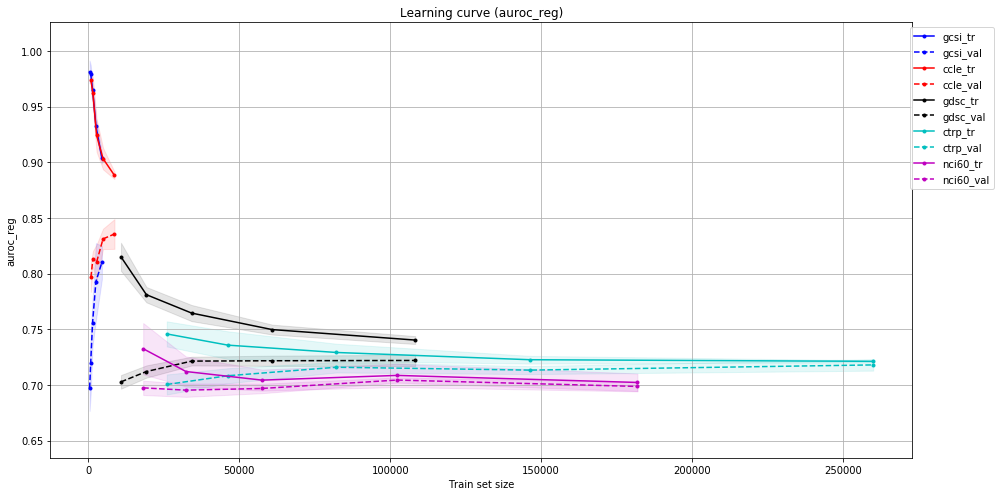

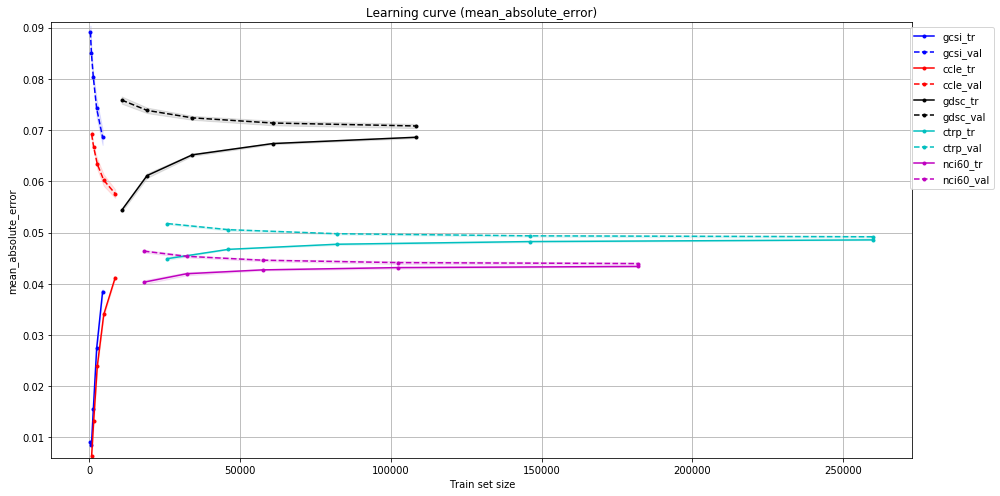

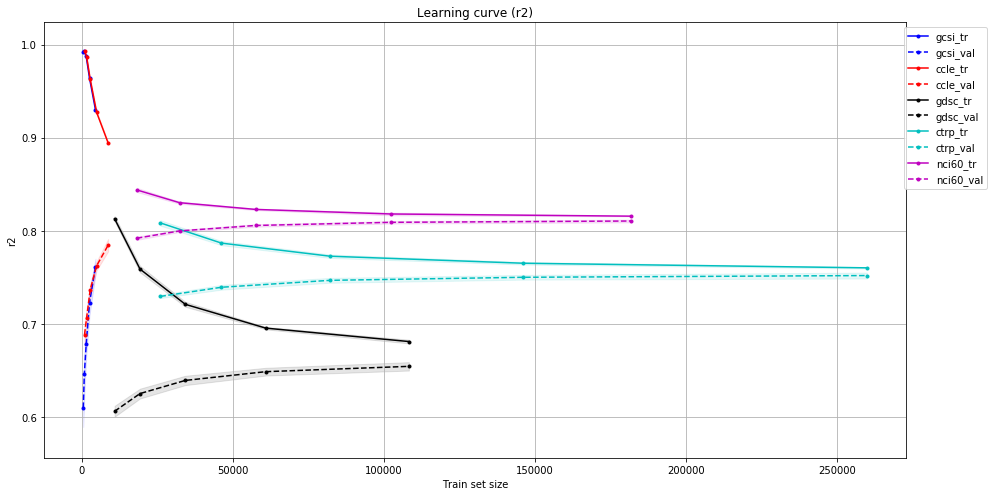

In [14]:
plot_agg_lrn_crv(df, outdir=run_path)